![Banner](images/banner.png)

# DML - INSERT, UPDATE, DELETE, and MERGE Statements

<hr>

Setup for this notebook:

In [11]:
import os
import oracledb

un = os.environ.get("PYO_SAMPLES_MAIN_USER", "pythondemo")
pw = os.environ.get("PYO_SAMPLES_MAIN_PASSWORD", "welcome")
cs = os.environ.get("PYO_SAMPLES_CONNECT_STRING", "localhost/orclpdb")

connection = oracledb.connect(user=un, password=pw, dsn=cs)

cursor = connection.cursor()
try:
    cursor.execute("drop table mytab")
except:
    pass
cursor.execute("create table mytab (id number, data varchar2(1000))")

# Binding for Insertion

Documentation reference link: [Using Bind Variables](https://python-oracledb.readthedocs.io/en/latest/user_guide/bind.html)

Binding is very, very important. 

Binding:
- eliminates escaping special characters and helps prevent SQL injection attacks
- is important for performance and scalability

In [12]:
cursor.execute("truncate table mytab")

sql = "insert into mytab (id, data) values (:idVal, :dataVal)"

# bind by position using a sequence (list or tuple)
cursor.execute(sql, [1, "String 1"])
cursor.execute(sql, (2, "String 2"))

# bind by name using a dictionary
cursor = connection.cursor()
cursor.execute(sql, {"idVal": 3, "dataVal": "String 3"})

# bind by name using keyword arguments
cursor.execute(sql, idVal=4, dataVal="String 4")

print("Done")

Done


# Batch execution - Inserting multiple rows with executemany()

Documentation reference link: [Executing Batch Statements and Bulk Loading](https://python-oracledb.readthedocs.io/en/latest/user_guide/batch_statement.html)

In [13]:
cursor.execute("truncate table mytab")

rows = [ (1, "First" ),
	 (2, "Second" ),
	 (3, "Third" ),
	 (4, "Fourth" ),
	 (5, "Fifth" ),
	 (6, "Sixth" ),
	 (7, "Seventh" ) ]

# Using setinputsizes helps avoid memory reallocations.
# The parameters correspond to the insert columns.  
# The value None says use python-oracledb's default size for a NUMBER column.  
# The second value is the maximum input data (or column) width for the VARCHAR2 column
cursor.setinputsizes(None, 7)

cursor.executemany("insert into mytab(id, data) values (:1, :2)", rows)

# Now query the results back

for row in cursor.execute('select * from mytab'):
    print(row)

connection.rollback()

(1, 'First')
(2, 'Second')
(3, 'Third')
(4, 'Fourth')
(5, 'Fifth')
(6, 'Sixth')
(7, 'Seventh')


### Performance - executemany() vs execute()

This script compares `executemany()` vs `execute()` and shows that `executemany()` is faster for inserting multiple records.  It may take several seconds for it to run and plot the graph.

execute() loop      1 rows in 0.0276 seconds
executemany()       1 rows in 0.0064 seconds
execute() loop      5 rows in 0.0259 seconds
executemany()       5 rows in 0.0065 seconds
execute() loop     10 rows in 0.0554 seconds
executemany()      10 rows in 0.0081 seconds
execute() loop    100 rows in 0.4570 seconds
executemany()     100 rows in 0.0207 seconds
execute() loop   1000 rows in 3.9817 seconds
executemany()    1000 rows in 0.1517 seconds
execute() loop   5000 rows in 20.7784 seconds
executemany()    5000 rows in 0.7431 seconds
Plot is:


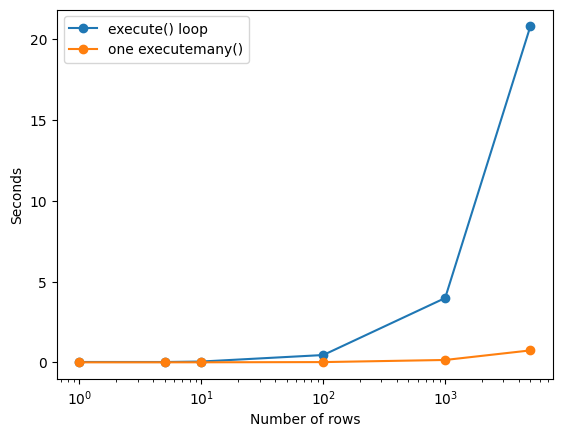

In [7]:
import matplotlib.pyplot as plt
import time

cursor = connection.cursor()
cursor.execute("truncate table mytab")

# Row counts to test inserting
numrows = (1, 5, 10, 100, 1000)

longstring = "x" * 1000

def create_data(n):
    d = []
    for i in range(n):
        d.append((i, longstring))
    return d

ex = []  # seconds for execute() loop
em = []  # seconds for executemany()

for n in numrows:
    
    rows = create_data(n)
    
    ############################################################
    #
    # Loop over each row
    #

    start=time.time()

    for r in rows:
        cursor.execute("insert into mytab(id, data) values (:1, :2)", r)          # <==== Loop over execute()
        
    elapsed = time.time() - start
    ex.append(elapsed)
    
    r, = cursor.execute("select count(*) from mytab").fetchone()
    print("execute() loop {:6d} rows in {:06.4f} seconds".format(r, elapsed))    
    connection.rollback()
    
    ############################################################# 
    #
    # Insert all rows in one call
    #

    start = time.time()

    cursor.executemany("insert into mytab(id, data) values (:1, :2)", rows)       # <==== One executemany()
    
    elapsed = time.time() - start
    em.append(elapsed)
    
    r, = cursor.execute("select count(*) from mytab").fetchone()
    print("executemany()  {:6d} rows in {:06.4f} seconds".format(r, elapsed))  
    connection.rollback()


print("Plot is:")
plt.xticks(numrows)
plt.plot(numrows, ex, label="execute() loop", marker="o")
plt.plot(numrows, em, label="one executemany()", marker="o")
plt.xscale("log")
plt.xlabel('Number of rows')
plt.ylabel('Seconds')
plt.legend(loc="upper left")
plt.show()

### Noisy Data - Batch Errors

Dealing with bad data is easy with the `batcherrors` parameter.

In [20]:
# Initial data

cursor.execute("truncate table mytab")

for row in cursor.execute("select * from ParentTable order by ParentId"):
    print(row)

for row in cursor.execute("select * from ChildTable order by ChildId"):
    print(row)

(10, 'Parent 10')
(20, 'Parent 20')
(30, 'Parent 30')
(40, 'Parent 40')
(50, 'Parent 50')
(1001, 10, 'Child A of Parent 10')
(1002, 20, 'Child A of Parent 20')
(1003, 20, 'Child B of Parent 20')
(1004, 20, 'Child C of Parent 20')
(1005, 30, 'Child A of Parent 30')
(1006, 30, 'Child B of Parent 30')
(1007, 40, 'Child A of Parent 40')
(1008, 40, 'Child B of Parent 40')
(1009, 40, 'Child C of Parent 40')
(1010, 40, 'Child D of Parent 40')
(1011, 40, 'Child E of Parent 40')
(1012, 50, 'Child A of Parent 50')
(1013, 50, 'Child B of Parent 50')
(1014, 50, 'Child C of Parent 50')
(1015, 50, 'Child D of Parent 50')
(1016, 10, 'Child Red')
(1018, 20, 'Child Blue')
(1022, 40, 'Child Yellow')


Additional data, some of it invalid:

In [21]:
dataToInsert = [
    (1016, 10, 'Child Red'),
    (1018, 20, 'Child Blue'),
    (1018, 30, 'Child Green'),  # duplicate key
    (1022, 40, 'Child Yellow'),
    (1021, 75, 'Child Orange')  # parent does not exist
]
    
cursor.executemany("insert into ChildTable values (:1, :2, :3)", dataToInsert, batcherrors=True)

print("\nErrors in rows that were not inserted:\n")
for error in cursor.getbatcherrors():
    print("Error", error.message, "at row offset", error.offset)   

print("\nRows that were successfully inserted:\n")
for row in cursor.execute("select * from ChildTable order by ChildId"):
    print(row)


Errors in rows that were not inserted:

Error ORA-00001: unique constraint (PYTHONDEMO.CHILDTABLE_PK) violated on table PYTHONDEMO.CHILDTABLE columns (CHILDID)
ORA-03301: (ORA-00001 details) row with column values (CHILDID:1016) already exists
Help: https://docs.oracle.com/error-help/db/ora-00001/ at row offset 0
Error ORA-00001: unique constraint (PYTHONDEMO.CHILDTABLE_PK) violated on table PYTHONDEMO.CHILDTABLE columns (CHILDID)
ORA-03301: (ORA-00001 details) row with column values (CHILDID:1018) already exists
Help: https://docs.oracle.com/error-help/db/ora-00001/ at row offset 1
Error ORA-00001: unique constraint (PYTHONDEMO.CHILDTABLE_PK) violated on table PYTHONDEMO.CHILDTABLE columns (CHILDID)
ORA-03301: (ORA-00001 details) row with column values (CHILDID:1018) already exists
Help: https://docs.oracle.com/error-help/db/ora-00001/ at row offset 2
Error ORA-00001: unique constraint (PYTHONDEMO.CHILDTABLE_PK) violated on table PYTHONDEMO.CHILDTABLE columns (CHILDID)
ORA-03301: (OR

Now you can choose whether or not to fix failed records and reinsert them.
You can then rollback or commit.

This is true even if you had enabled autocommit mode - no commit will occur if there are batch errors.

In [ ]:
# Roll back so the example can be re-run
connection.rollback()

# Direct Path Loads

Documentation reference link: [Direct Path Loads](https://python-oracledb.readthedocs.io/en/latest/user_guide/batch_statement.html#direct-path-loads)

Direct Path Loading is an Oracle Database feature most commonly known from SQL*Loader. It is efficient for ingesting very large data sets into Oracle Database.

In [ ]:
SCHEMA_NAME = "pythondemo"
TABLE_NAME = "mytab"
COLUMN_NAMES = ["id", "data"]
DATA = [
    (1, "A first row"),
    (2, "A second row"),
    (3, "A third row")
]

connection.direct_path_load(
    schema_name=SCHEMA_NAME,
    table_name=TABLE_NAME,
    column_names=COLUMN_NAMES,
    data=DATA
)

Direct Path Loads are efficient because some Oracle Database code layers are bypassed. There are also no INSERT statements involved. This means there are a few restrictions on when to use the feature: refer to Oracle Database documentation such as SQL*Loader [Direct Path Loads](https://www.oracle.com/pls/topic/lookup?ctx=dblatest&id=GUID-0D576DEF-7918-4DD2-A184-754D217C021F).

In [ ]:
# Verify inserted data

for row in cursor.execute('select * from mytab'):
    print(row)

Note that the data is automatically committed.

In [ ]:
# Remove the data so the sample can be re-run cleanly

cursor.execute("truncate table mytab")
connection.commit()